# 01_parse_itch_order_flow_messages.ipynb

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import gzip
import shutil
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Path: Provides an object-oriented interface for working with filesystem paths
# Counter: A dict subclass for counting hashable objects
# namedtuple: Factory function for creating tuple subclasses with named fields
# defaultdict: Dict subclass that calls a factory function to supply missing values
# unpack: Unpack binary data according to a format string
# timedelta: A duration expressing the difference between two date, time, or datetime instances
# time: Provides various time-related functions

# pandas: Data manipulation and analysis library
# numpy: Numerical computing library for large, multi-dimensional arrays and matrices

# matplotlib.pyplot: MATLAB-like plotting interface
# FuncFormatter: Create a function formatter for tick labels
# seaborn: Statistical data visualization library built on matplotlib

In [3]:
# Set the default style for seaborn plots
# This applies a white background with a grid for better readability
sns.set_style('whitegrid')

def format_time(t):
    """Return a formatted time string 'HH:MM:SS'
    based on a numeric time() value"""

    # Divide the total seconds into hours, minutes, and seconds
    m, s = divmod(t, 60)  # First, divide into minutes and remaining seconds
    h, m = divmod(m, 60)  # Then, divide minutes into hours and remaining minutes

    # Return a formatted string with zero-padded values
    # {:0>2.0f} means:
    #   :     start format spec
    #   0     pad with zeros
    #   >     right-align
    #   2     width of 2 characters
    #   .0f   floating point with 0 decimal places
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>5.2f}'

# Set the data paths
data_path = Path('data')  # Create a Path object for the 'data' directory
itch_store = str(data_path / 'itch.h5')  # Path for storing processed ITCH data
order_book_store = data_path / 'order_book.h5'  # Path for storing order book data

# Set the date for the data we're working with
date = '10302019'  # October 30, 2019

# Set the HTTPS URL for the NASDAQ ITCH data
HTTPS_URL = 'https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/'

# Set the filename for the source data
SOURCE_FILE = '10302019.NASDAQ_ITCH50.gz'

In [4]:
def may_be_download(url):
    """Download & unzip ITCH data if not yet available"""
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir()  # Create the data directory if it doesn't exist
    else:
        print('Directory exists')

    filename = data_path / url.split('/')[-1]  # Extract filename from URL
    if not filename.exists():
        print('Downloading...', url)
        urlretrieve(url, filename)  # Download the file if it doesn't exist locally
    else:
        print('File exists')

    unzipped = data_path / (filename.stem + '.bin')  # Path for unzipped file
    if not unzipped.exists():
        print('Unzipping to', unzipped)
        with gzip.open(str(filename), 'rb') as f_in:  # Open gzipped file
            with open(unzipped, 'wb') as f_out:  # Open new file for binary writing
                shutil.copyfileobj(f_in, f_out)  # Copy contents, effectively unzipping
    else:
        print('File already unpacked')
    return unzipped

# This will download 5.1GB data that unzips to 12.9GB (this may vary depending on the file)
file_name = may_be_download(urljoin(HTTPS_URL, SOURCE_FILE))
date = file_name.name.split('.')[0]  # Extract date from filename

Creating directory
Downloading... https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/10302019.NASDAQ_ITCH50.gz
Unzipping to data/10302019.NASDAQ_ITCH50.bin


In [5]:
# Define event codes for system events
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

# Define encoding mappings for various fields
encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

# Define format strings for different data types and lengths
formats = {
    ('integer', 2): 'H',  # unsigned short integer
    ('integer', 4): 'I',  # unsigned integer
    ('integer', 6): '6s',  # string of 6 bytes (to be interpreted as integer later)
    ('integer', 8): 'Q',  # unsigned long long integer
    ('alpha', 1): 's',    # string of 1 byte
    ('alpha', 2): '2s',   # string of 2 bytes
    ('alpha', 4): '4s',   # string of 4 bytes
    ('alpha', 8): '8s',   # string of 8 bytes
    ('price_4', 4): 'I',  # price stored as integer
    ('price_8', 8): 'Q',  # price stored as long long integer
}

In [6]:
# Load message types from an Excel file
message_data = (pd.read_excel('message_types.xlsx',
                              sheet_name='messages')
                .sort_values('id')
                .drop('id', axis=1))

def clean_message_types(df):
    """Clean and format the message types dataframe"""
    df.columns = [c.lower().strip() for c in df.columns]  # Lowercase and strip column names
    df.value = df.value.str.strip()  # Strip whitespace from 'value' column
    df.name = (df.name
               .str.strip()  # Remove whitespace
               .str.lower()  # Convert to lowercase
               .str.replace(' ', '_')  # Replace spaces with underscores
               .str.replace('-', '_')  # Replace hyphens with underscores
               .str.replace('/', '_'))  # Replace slashes with underscores
    df.notes = df.notes.str.strip()  # Strip whitespace from 'notes' column
    # Add a 'message_type' column based on 'name' and 'value' columns
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df

# Apply cleaning function to message types
message_types = clean_message_types(message_data)

# Extract message labels for later use
message_labels = (message_types.loc[:, ['message_type', 'notes']]
                  .dropna()
                  .rename(columns={'notes': 'name'}))
message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))

# Further process message types
message_types.message_type = message_types.message_type.ffill()  # Forward fill message type
message_types = message_types[message_types.name != 'message_type']  # Remove 'message_type' rows
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))

message_types.to_csv('message_types.csv', index=False)
message_types = pd.read_csv('message_types.csv')

# Create format tuples for each message type
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                                   .apply(tuple, axis=1).map(formats))

# Extract formatting details for alphanumeric fields
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

# Generate message classes as named tuples and format strings
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())

# Function to process byte strings of type alpha
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""
    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

In [7]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # Convert to DataFrame
            data = pd.DataFrame(data)

            # Parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # Apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            # Convert all object columns to strings
            for col in data.select_dtypes(include=['object']):
                data[col] = data[col].astype(str)

            # Prepare for storing
            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns}
            dc = ['stock_locate']
            if mtype == 'R':
                dc.append('stock')

            # Attempt to store the data
            try:
                store.append(mtype,
                             data,
                             format='t',
                             min_itemsize=s,
                             data_columns=dc)
            except Exception as e:
                print(e)
                print(mtype)
                print(data.info())
                print(pd.Series(list(m.keys())).value_counts())
                data.to_csv('data.csv', index=False)
                return 1
    return 0

# Initialize data structures for message processing
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

# Main processing loop
start = time()
with file_name.open('rb') as data:
    while True:
        # Determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)

        # Get message type by reading first byte
        message_type = data.read(1).decode('ascii')
        message_type_counter.update([message_type])

        # Read & store message
        try:
            record = data.read(message_size - 1)
            message = message_fields[message_type]._make(unpack(fstring[message_type], record))
            messages[message_type].append(message)
        except Exception as e:
            print(e)
            print(message_type)
            print(record)
            print(fstring[message_type])

        # Deal with system events
        if message_type == 'S':
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}')
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break
        message_count += 1

        # Periodically store messages and report progress
        if message_count % 2.5e7 == 0:
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
            res = store_messages(messages)
            if res == 1:
                print(pd.Series(dict(message_type_counter)).sort_values())
                break
            messages.clear()

print('Duration:', format_time(time() - start))


 Start of Messages
	03:02:31.65	           0

 Start of System Hours
	04:00:00.00	     241,258

 Start of Market Hours
	09:30:00.00	   9,559,279
	09:44:09.23	  25,000,000	00:01:10.47
	10:07:45.15	  50,000,000	00:04:13.68
	10:39:56.24	  75,000,000	00:07:00.41
	11:18:09.64	 100,000,000	00:09:52.87
	11:58:35.35	 125,000,000	00:12:39.33
	12:44:20.61	 150,000,000	00:15:24.30
	13:41:03.75	 175,000,000	00:18:08.06
	14:18:44.52	 200,000,000	00:21:15.86
	14:49:19.38	 225,000,000	00:24:06.27
	15:19:40.72	 250,000,000	00:26:53.97
	15:50:23.01	 275,000,000	00:30:07.67

 End of Market Hours
	16:00:00.00	 290,920,164

 End of System Hours
	20:00:00.00	 293,944,863

 End of Messages
	20:05:00.00	 293,989,078
Duration: 00:34:30.60


In [11]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create ML4T folder if it doesn't exist
ml4t_folder = '/content/drive/My Drive/ML4T'
if not os.path.exists(ml4t_folder):
    os.makedirs(ml4t_folder)
    print(f"Created folder: {ml4t_folder}")
else:
    print(f"Folder already exists: {ml4t_folder}")

Mounted at /content/drive
Created folder: /content/drive/My Drive/ML4T


In [12]:
import shutil

source_file = '/content/data/itch.h5'
destination_file = os.path.join(ml4t_folder, 'itch.h5')

shutil.copy2(source_file, destination_file)
print(f"Copied {source_file} to {destination_file}")

Copied /content/data/itch.h5 to /content/drive/My Drive/ML4T/itch.h5


In [13]:
## Summarize Trading Day

### Trading Message Frequency

# Create a DataFrame from the message type counter
counter = pd.Series(message_type_counter).to_frame('# Trades')

# Map message types to their descriptive names
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())

# Sort the counter by number of trades in descending order
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)

# Display the counter
print(counter)

# Store the summary in the HDF5 file
with pd.HDFStore(itch_store) as store:
    store.put('summary', counter)



                                        Message Type   # Trades
A                      add_order_no_mpid_attribution  127214649
D                                       order_delete  123296742
U                                      order_replace   25513651
E                                     order_executed    7316703
I                                               noii    3740140
X                                       order_cancel    3568735
P                                              trade    1525363
F                         add_order_mpid_attribution    1423908
L                        market_participant_position     214865
C                          order_executed_with_price     129729
Q                                        cross_trade      17775
Y  reg_sho_short_sale_price_test_restricted_indic...       9025
H                               stock_trading_action       8897
R                                    stock_directory       8887
S                                       

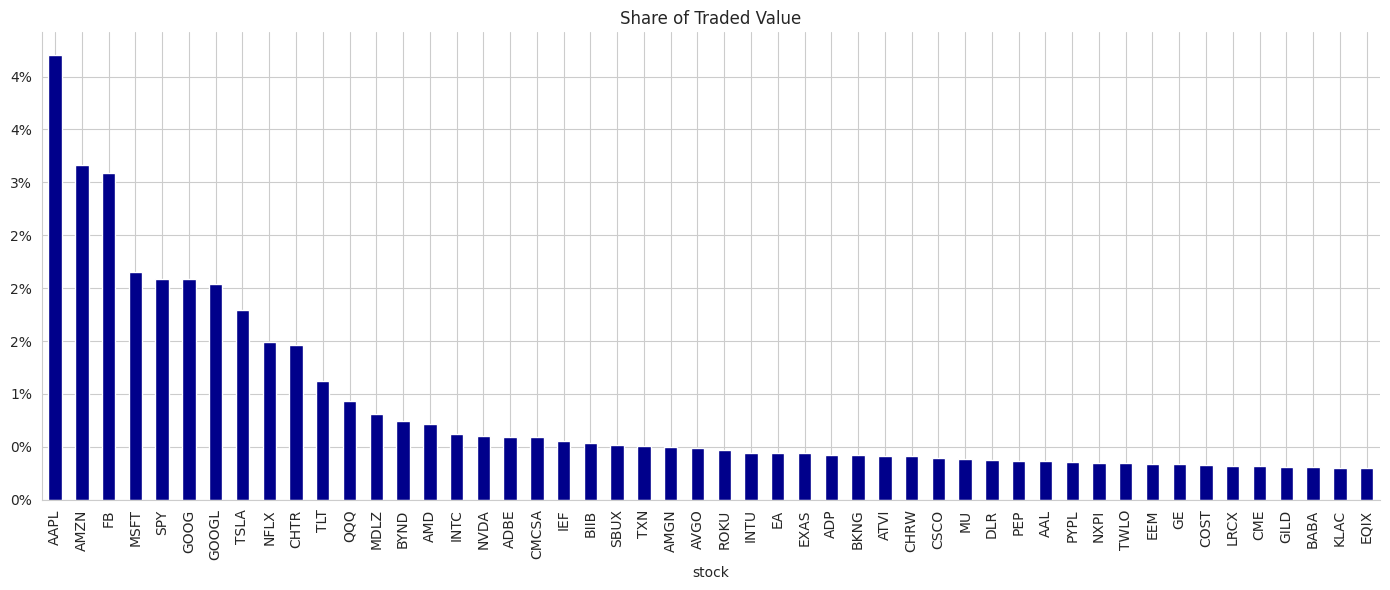

In [14]:
### Top Equities by Traded Value

# Open the HDF5 store and retrieve stock and trade data
with pd.HDFStore(itch_store) as store:
    # Get stock information
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]

    # Get trade information, combining 'P' (Trade) and 'Q' (Cross Trade) messages
    trades_P = store['P']
    trades_Q = store['Q'].rename(columns={'cross_price': 'price'})
    trades = pd.concat([trades_P, trades_Q], axis=0, sort=False)
    trades = trades.merge(stocks)

# Calculate the total value traded for each transaction
trades['value'] = trades.shares.mul(trades.price)

# Calculate the share of total traded value for each transaction
trades['value_share'] = trades.value.div(trades.value.sum())

# Group by stock and sum the value shares
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)

# Plot the top 50 stocks by traded value
trade_summary.iloc[:50].plot.bar(figsize=(14, 6),
                                 color='darkblue',
                                 title='Share of Traded Value')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Remove top and right spines from the plot for a cleaner look
sns.despine()

# Adjust the layout to prevent clipping of labels
plt.tight_layout()

# Display the plot (this is implicit in Jupyter notebooks, but explicit in scripts)
plt.show()

In [15]:
import pandas as pd
import tables

def inspect_hdf_store(file_path):
    with pd.HDFStore(file_path, mode='r') as store:
        print(f"Keys in the HDF5 store:")
        for key in store.keys():
            print(f"\nInspecting key: {key}")

            # Get the data for this key
            df = store.get(key)

            print(f"Shape: {df.shape}")
            print("\nColumns and their data types:")
            for column, dtype in df.dtypes.items():
                print(f"{column}: {dtype}")

            print("\nFirst few rows:")
            print(df.head())

            print("\nMemory usage:")
            print(df.memory_usage(deep=True))

            # If you want to see some statistics for numeric columns
            print("\nNumeric columns statistics:")
            print(df.describe())

# Use the function
inspect_hdf_store(file_path=itch_store)

Keys in the HDF5 store:

Inspecting key: /A
Shape: (127214649, 7)

Columns and their data types:
stock_locate: int64
tracking_number: int64
timestamp: timedelta64[ns]
order_reference_number: int64
buy_sell_indicator: object
shares: int64
price: int64

First few rows:
   stock_locate  tracking_number                 timestamp  \
0          6963                0 0 days 04:00:00.001313761   
1          6963                0 0 days 04:00:00.001401480   
2          6963                0 0 days 04:00:00.001445278   
3          6963                0 0 days 04:00:00.001488348   
4          6537                0 0 days 04:00:00.002902396   

   order_reference_number buy_sell_indicator  shares    price  
0                      11                  1    3400    71100  
1                      35                  1   12500    70800  
2                      47                 -1    4800    71600  
3                      51                 -1   12500    71900  
4                     191              

In [16]:
import pandas as pd
import numpy as np

def convert_buy_sell_indicator(file_path):
    with pd.HDFStore(file_path, mode='r+') as store:
        keys_to_process = [key for key in store.keys() if 'buy_sell_indicator' in store.get(key).columns]

        for key in keys_to_process:
            print(f"Processing {key}...")

            # Read the data
            df = store.get(key)

            # Convert buy_sell_indicator to integer
            df['buy_sell_indicator'] = pd.to_numeric(df['buy_sell_indicator'], errors='coerce')

            # Replace NaN with a sentinel value (e.g., 0) if needed
            df['buy_sell_indicator'] = df['buy_sell_indicator'].fillna(0)

            # Convert to standard int64
            df['buy_sell_indicator'] = df['buy_sell_indicator'].astype('int64')

            # Check for any unexpected values
            unexpected = df[~df['buy_sell_indicator'].isin([1, -1, 0])]['buy_sell_indicator'].unique()
            if len(unexpected) > 0:
                print(f"Warning: Unexpected values found in {key}: {unexpected}")

            # Write the modified data back to the store
            store.put(key, df, format='table', data_columns=True, index=False)

        print("Conversion completed.")


# Use the function
convert_buy_sell_indicator(file_path=itch_store)

Processing /A...
Processing /F...
Processing /P...
Conversion completed.


In [17]:
import shutil

source_file = '/content/data/itch.h5'
destination_file = os.path.join(ml4t_folder, 'itch.h5')

shutil.copy2(source_file, destination_file)
print(f"Copied {source_file} to {destination_file}")

Copied /content/data/itch.h5 to /content/drive/My Drive/ML4T/itch.h5
